In [1]:
## Updated 1-7-25


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
from joblib import load
import time
import unsupervised_scripts
import helper_scripts
from tkinter import Tk, filedialog


## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())


## Load Image
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

indeces = [index for index, char in enumerate(sample[0]) if char=='/']
sample_name = sample[0][indeces[-1]+1:]

data_dir = sample[0][:indeces[-2]+1]

save_dir = data_dir+sample_name+'/'
if os.path.exists(save_dir) is False:
  os.mkdir(save_dir)

## Remove NaNs and inf
image[np.isinf(image)] = 0
image[np.isnan(image)] = 0

## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(image_vec.shape[1])
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')

### Semi-Supervised Learning

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_norm = preprocessing.spectral_standardization(np.flip(image_vec,axis=1), br_shift=0)
save_input = helper_scripts.save_input()


2025-03-12 14:41:43.345 python[9171:585999] +[IMKClient subclass]: chose IMKClient_Modern
2025-03-12 14:41:43.596 python[9171:585999] The class 'NSOpenPanel' overrides the method identifier.  This method is implemented by class 'NSWindow'


Text(0.5, 1.0, 'Spectra Peak Intensity')

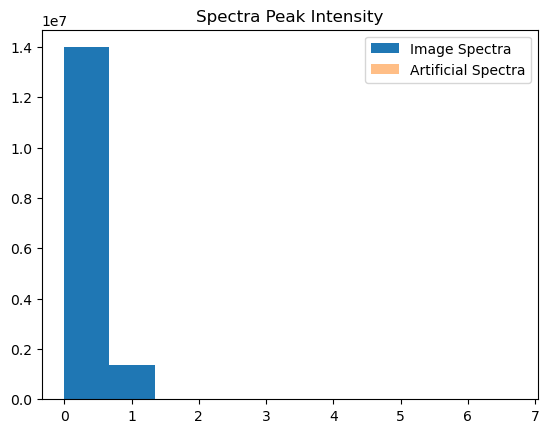

In [2]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0], label = "Image Spectra")
plt.hist(np.max(X_norm,axis=1)-X_norm[:,0],alpha=0.5, label = "Artificial Spectra")
plt.legend()
plt.title("Spectra Peak Intensity")

In [3]:
def macro_idx(wavenumber, num_samp, wavenum_1=2700, wavenum_2=3100):
    idx = int(((wavenumber - wavenum_1) / (wavenum_2 - wavenum_1)) * num_samp)
    return idx

In [4]:
## Save Normalized Image and channels (ONLY FOR 2700-3100)
unsat_idx = macro_idx(3010, num_samp, wavenum_1, wavenum_2)
protein_idx = macro_idx(2938, num_samp, wavenum_1, wavenum_2)
sat_idx = macro_idx(2885, num_samp, wavenum_1, wavenum_2)
lipid_idx = macro_idx(2850, num_samp, wavenum_1, wavenum_2)



norm_image = np.reshape(image_norm, (image.shape[1],image.shape[2],image.shape[0]))
norm_image = np.moveaxis(norm_image, 2, 0)
io.imsave(save_dir+'normalized-'+sample_name, norm_image.astype('float32'))
io.imsave(save_dir+'normalized-unsat-'+sample_name, np.max(norm_image[list(range(unsat_idx-1, unsat_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-protein-'+sample_name, np.max(norm_image[list(range(protein_idx-1, protein_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-sat-'+sample_name, np.max(norm_image[list(range(sat_idx-1, sat_idx+1))],axis=0).astype('float32'))
io.imsave(save_dir+'normalized-lipid-'+sample_name, np.max(norm_image[list(range(lipid_idx-1, lipid_idx+1))],axis=0).astype('float32'))

Text(0, 0.5, 'Normalized Intensity (A.U.)')

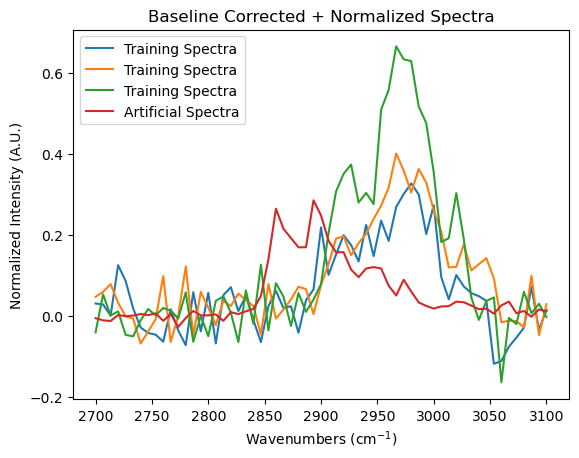

In [8]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Training Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])].T, label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [ ]:
# ## Optimize Smoothing of HSI and artificial spectra
# w = int(input('Enter window size for Savitzky-Golay smoothing (Default=6): ').strip() or '6')
# p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
# preprocessing.sav_gol_optimization(image_norm, w, p)
# preprocessing.sav_gol_optimization(X_norm, w, p)
# x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
# X = savgol_filter(X_norm,w,p, axis=1, mode='mirror')
# smooth = 'smoothing-'+str(w)+'-'+str(p)

In [9]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm

smooth = 'No Smoothing'

Accuracy Score: 1.0


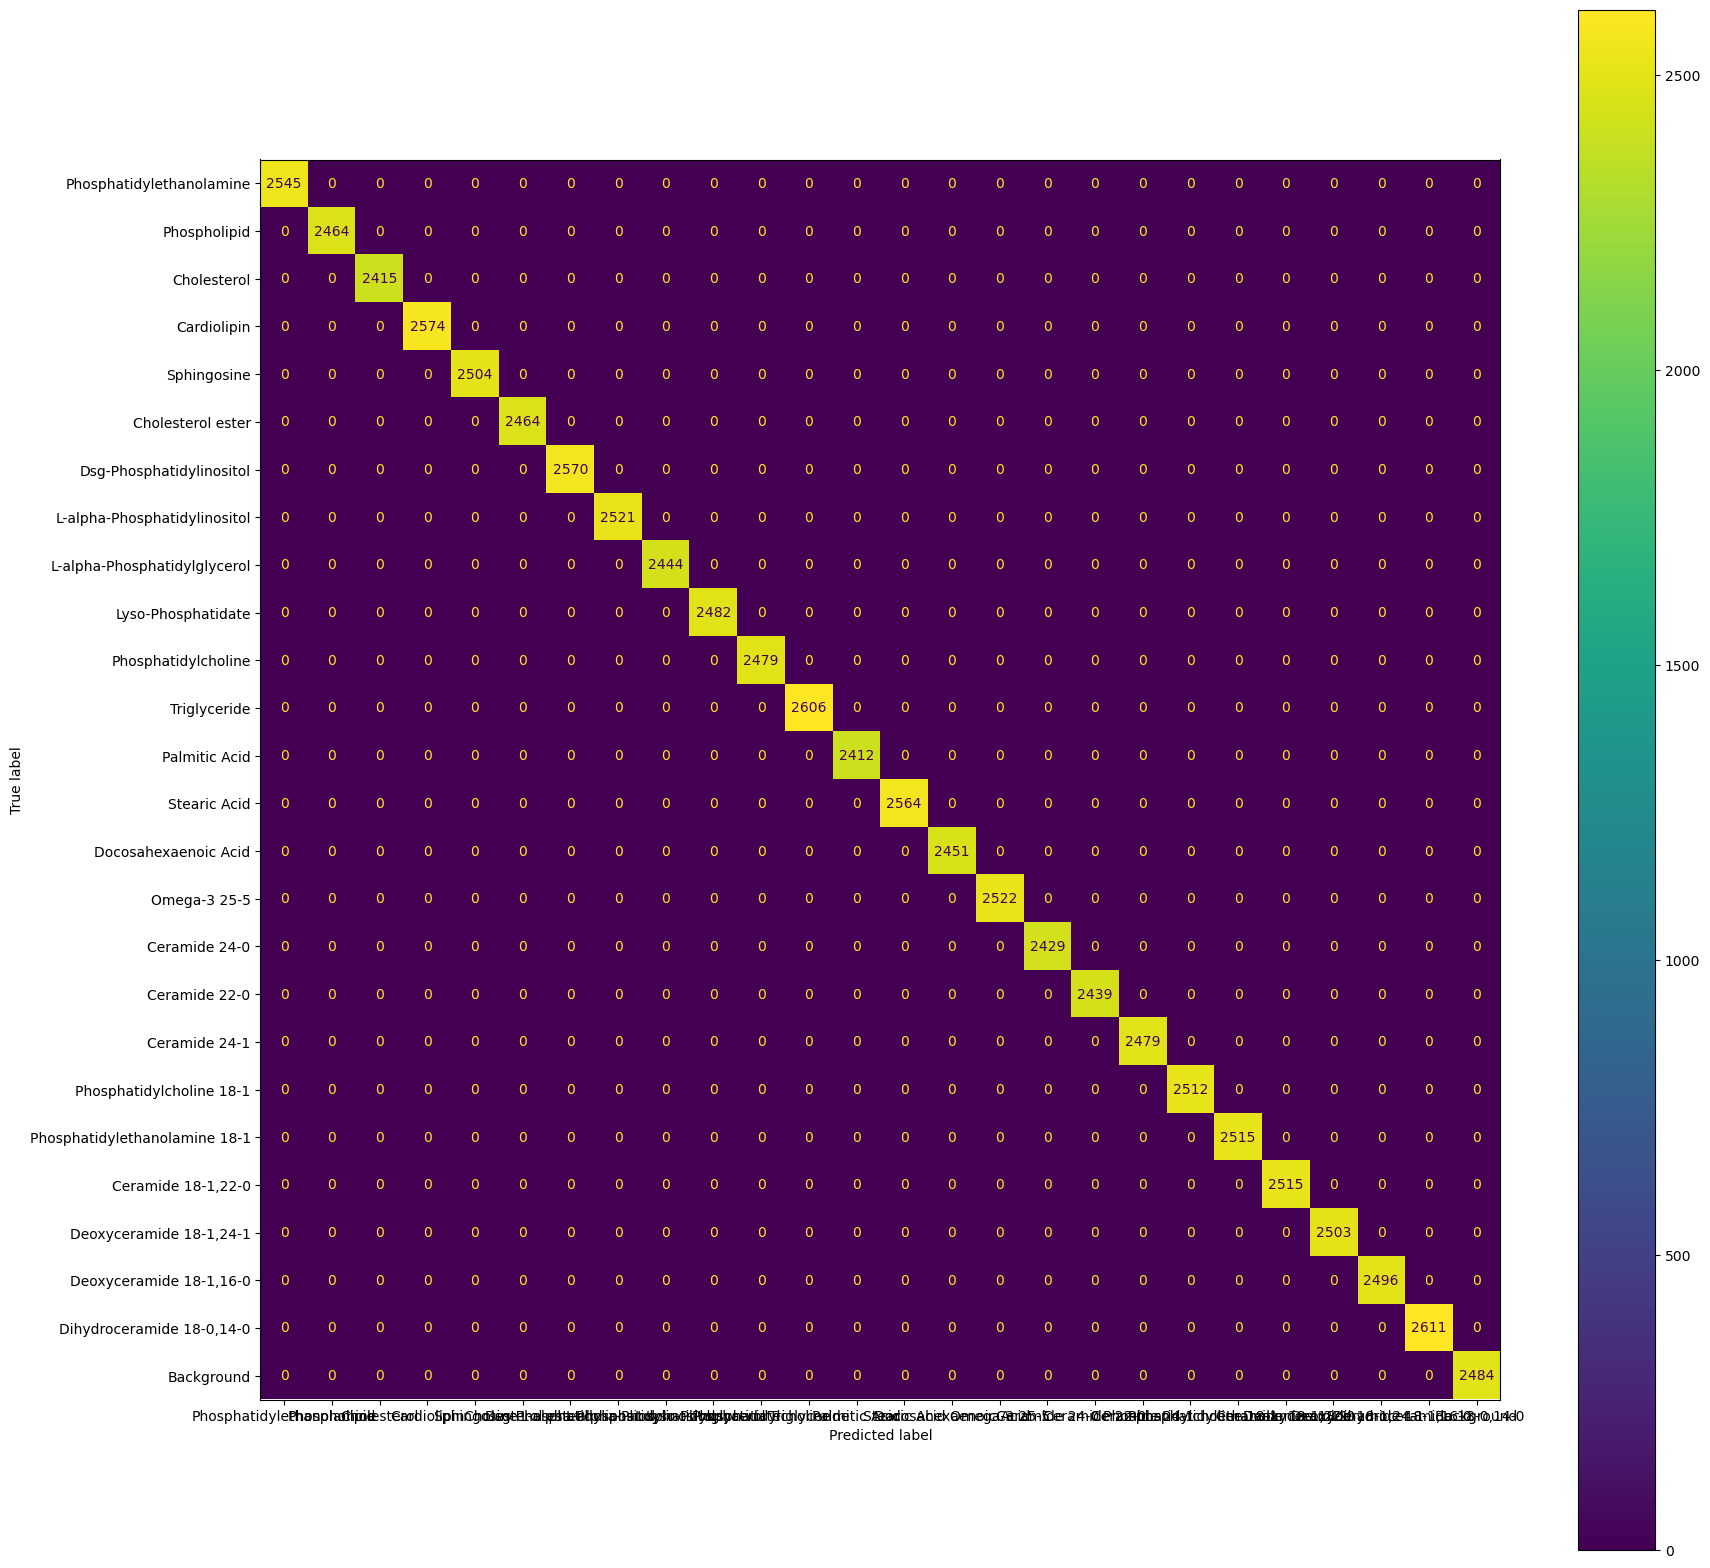

In [11]:
## Random Forest Classification
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
num_estimators =500
rfc = load('rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'_'+str(num_estimators)+'.joblib')
print('Accuracy Score: ' + str(rfc.score(rf_classifier.X_train, rf_classifier.y_train)))
rf_classifier.confusion_matrix(mol_names, rfc)

In [12]:
## USe Random Forest Classifier on Unlabeled HSI
start_time = time.time()
outputs = unsupervised_scripts.semi_supervised_outputs(x, mol_names, rfc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 109.49769902229309 seconds


 88%|████████▊ | 22/25 [00:03<00:00,  8.12it/s]/Users/jorgevillazon/Documents/GitHub/hsi_machine_learning/ML/unsupervised_scripts.py:441: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(10, 8))
 48%|████▊     | 12/25 [00:03<00:03,  3.27it/s]/Users/jorgevillazon/miniconda3/envs/ML/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Volumes/ADATA SE880/02-10-25 CosMX Bottom/Bottom-zoom4/Cortex/1.4-HSI.tif/Palmitic Acid-Probability_Figure.tif is a low contrast image
  return func(*args, **kwargs)
 64%|██████▍   | 16/25 [00:04<00:02,  3.32it/s]/Users/jorgevillazon/miniconda3/envs/ML/lib/python3.12/site-packages/skimage/_shared/utils.py:328: UserWarning: /Volumes/ADATA SE880/02-10-2

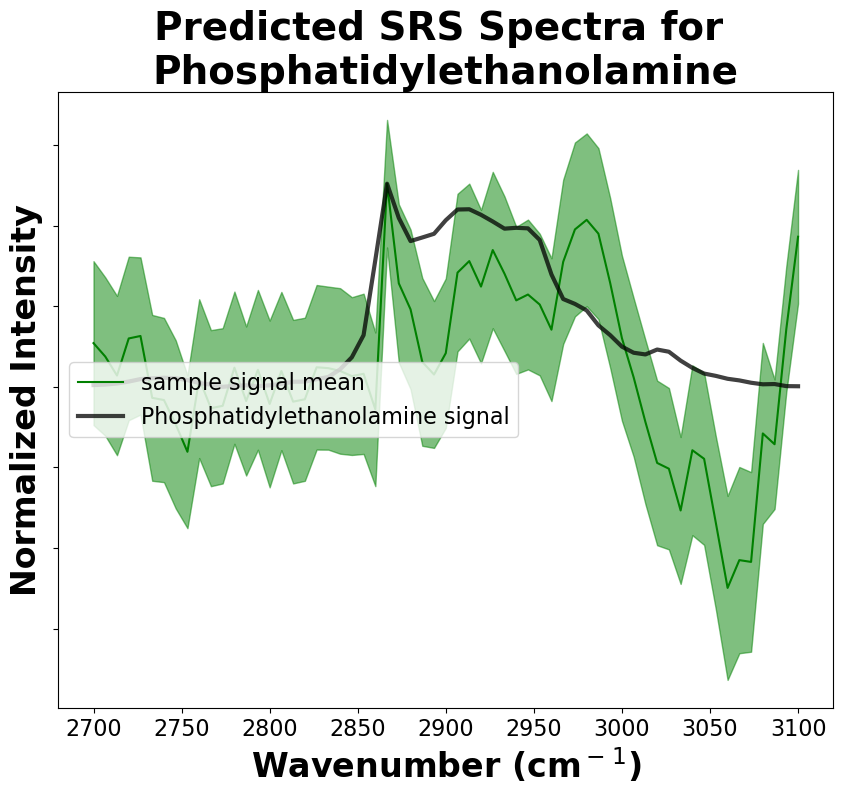

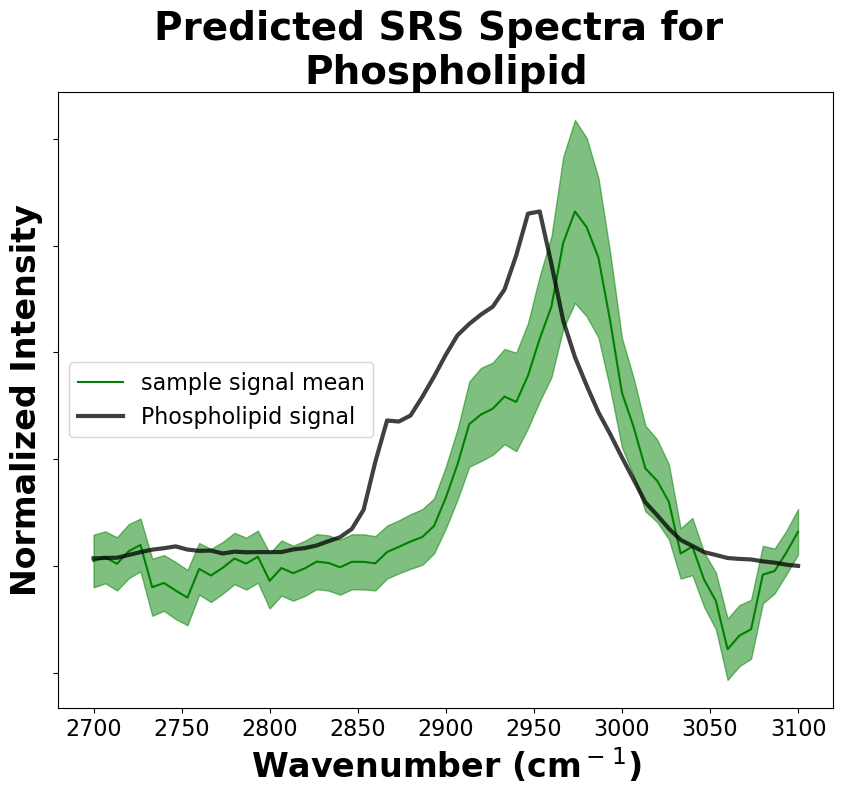

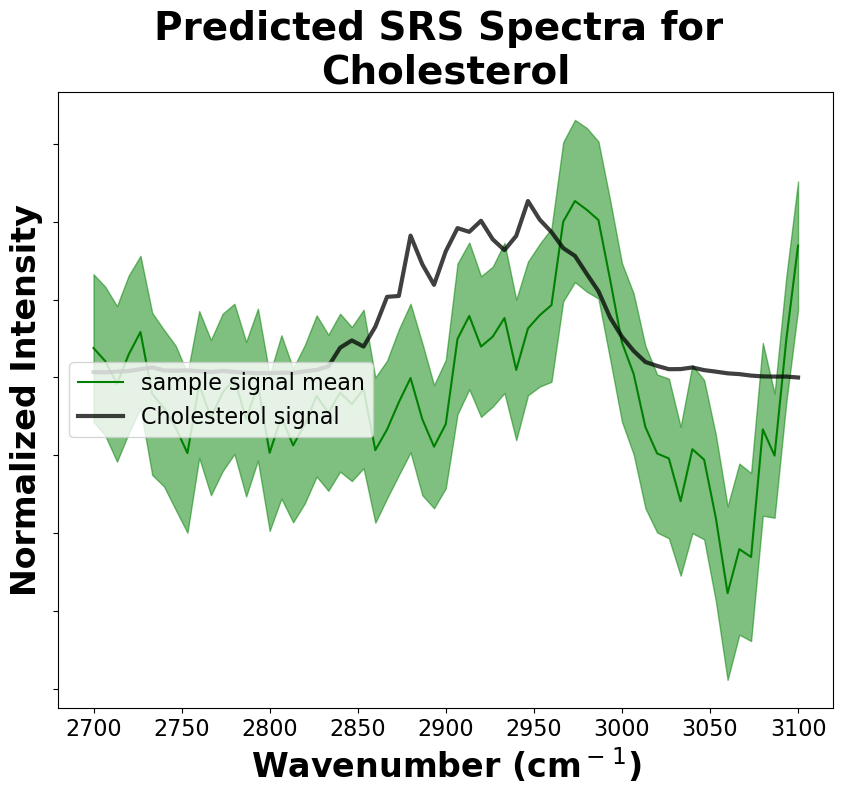

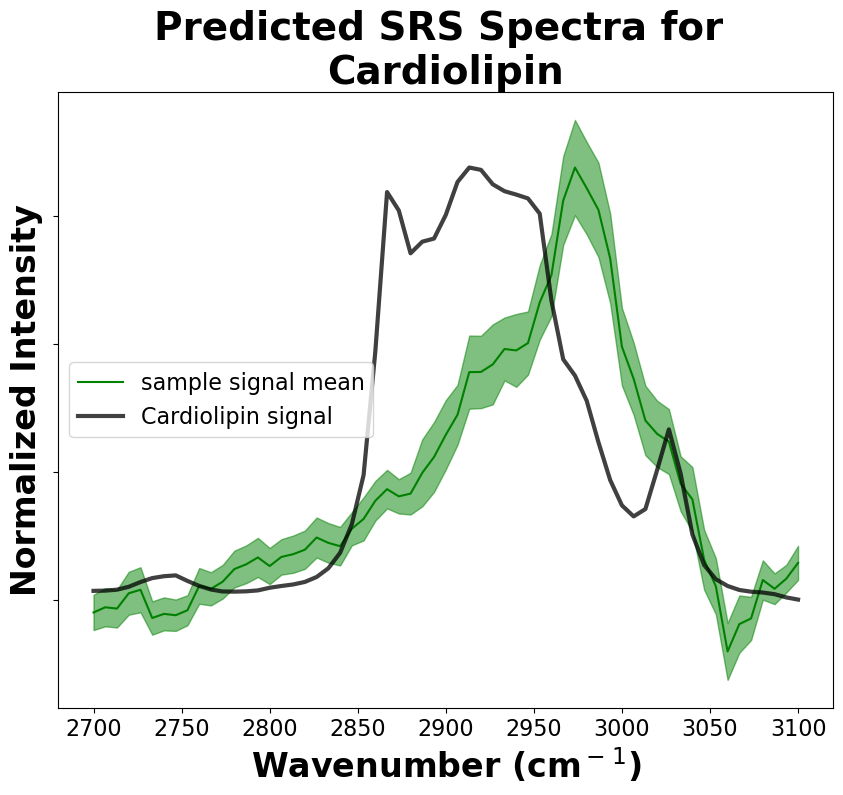

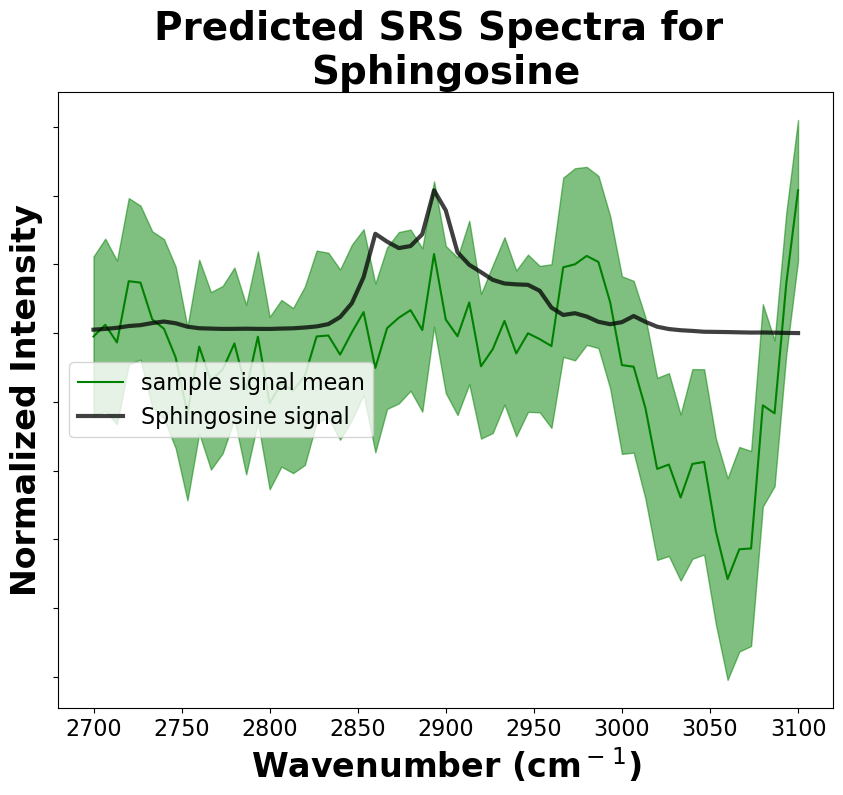

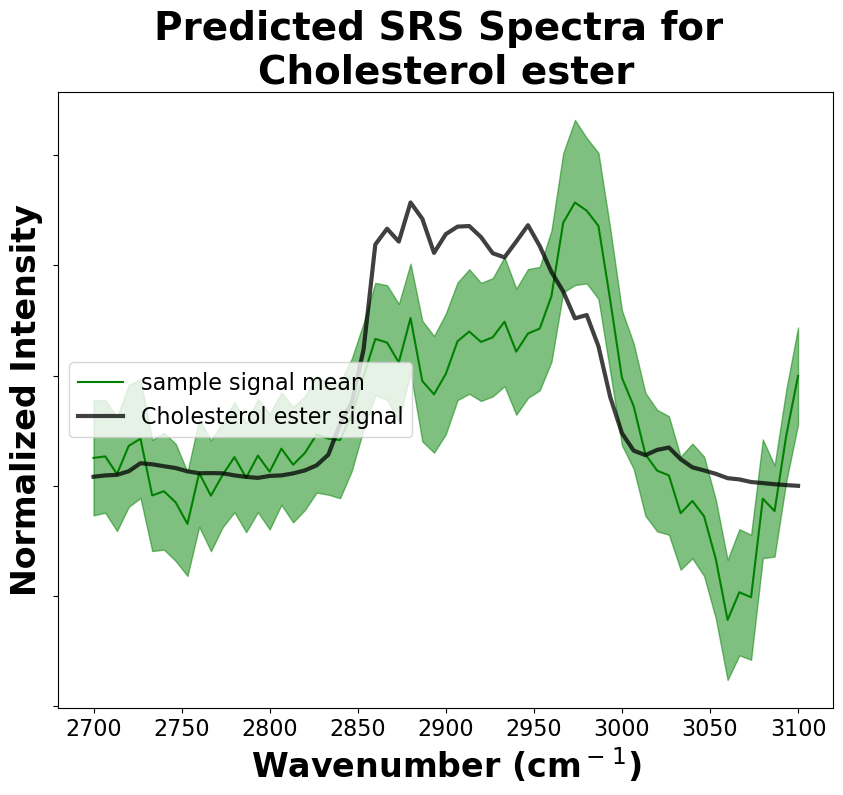

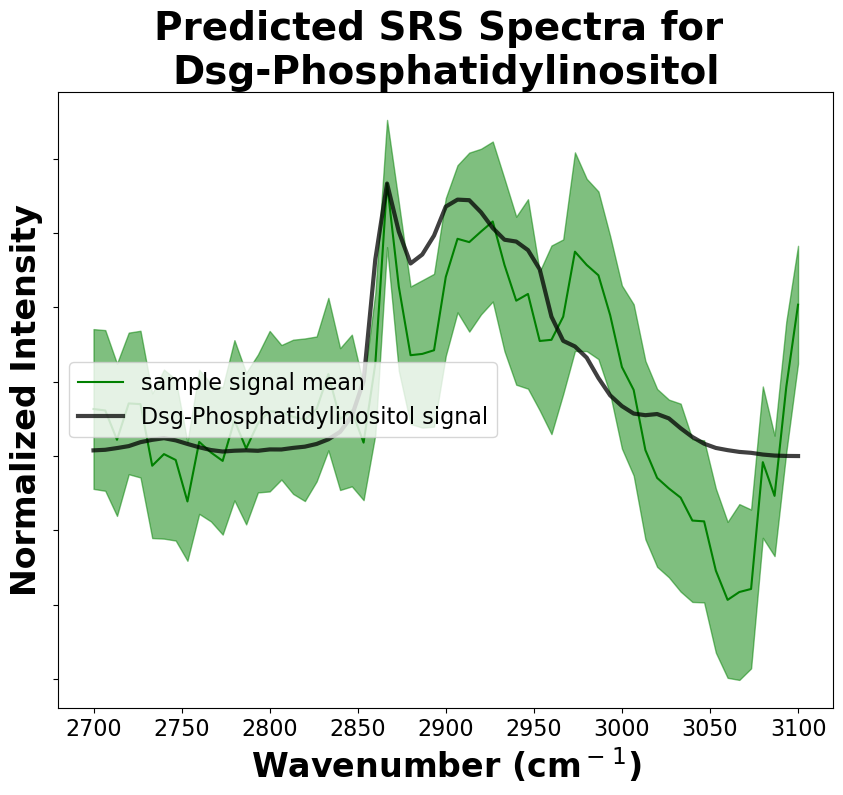

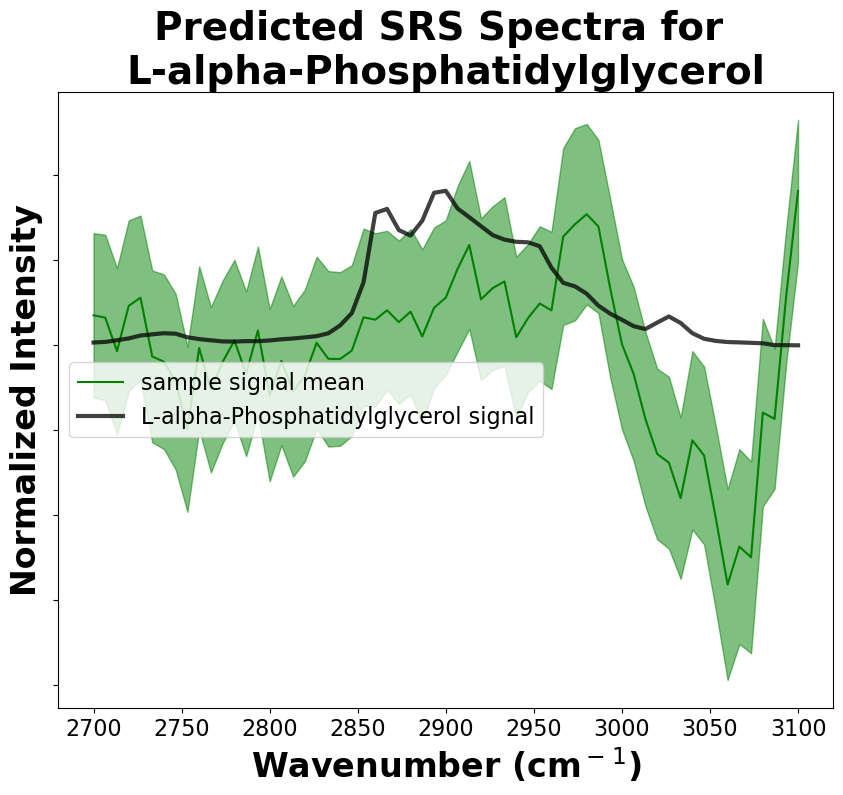

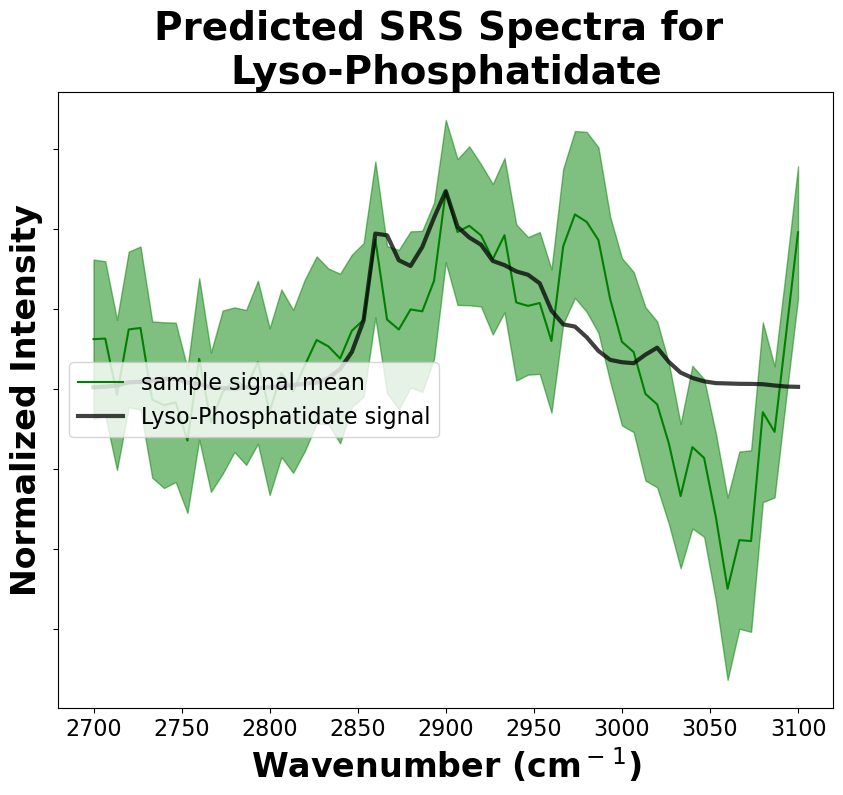

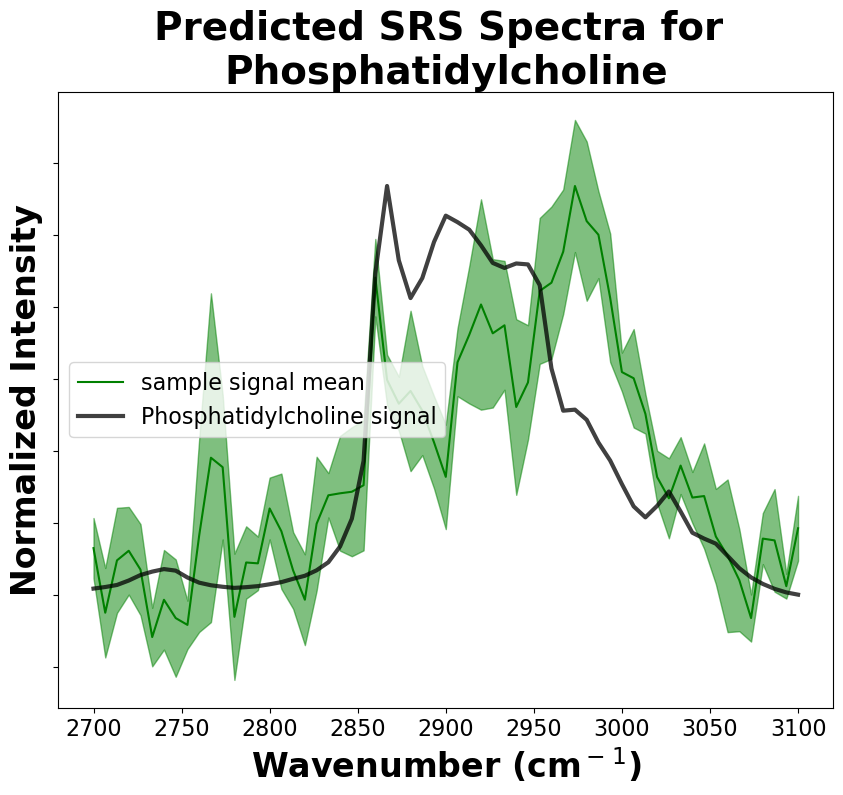

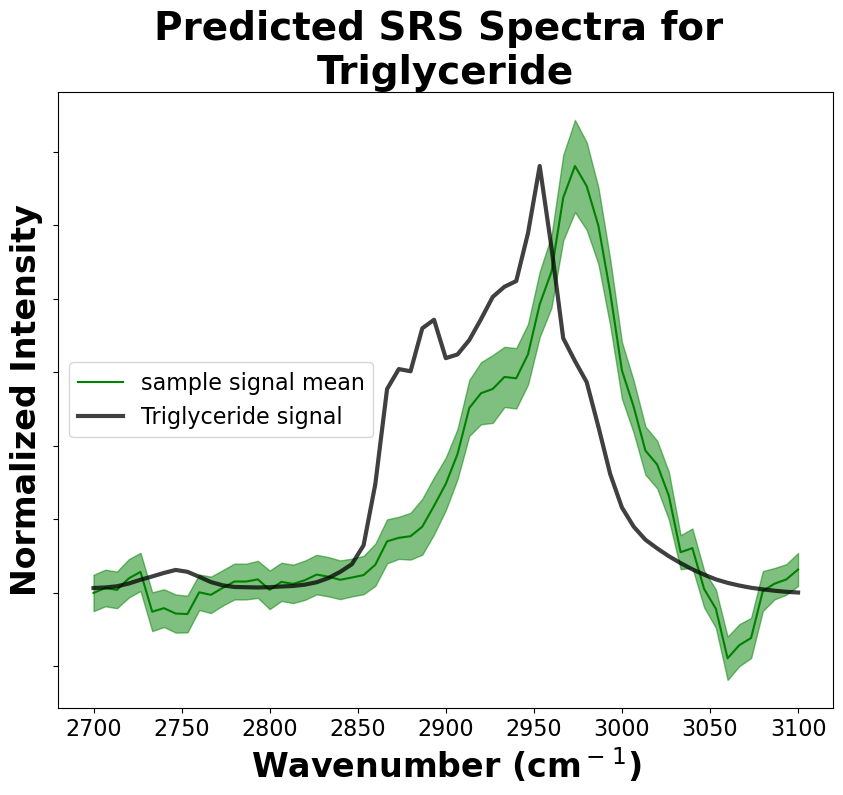

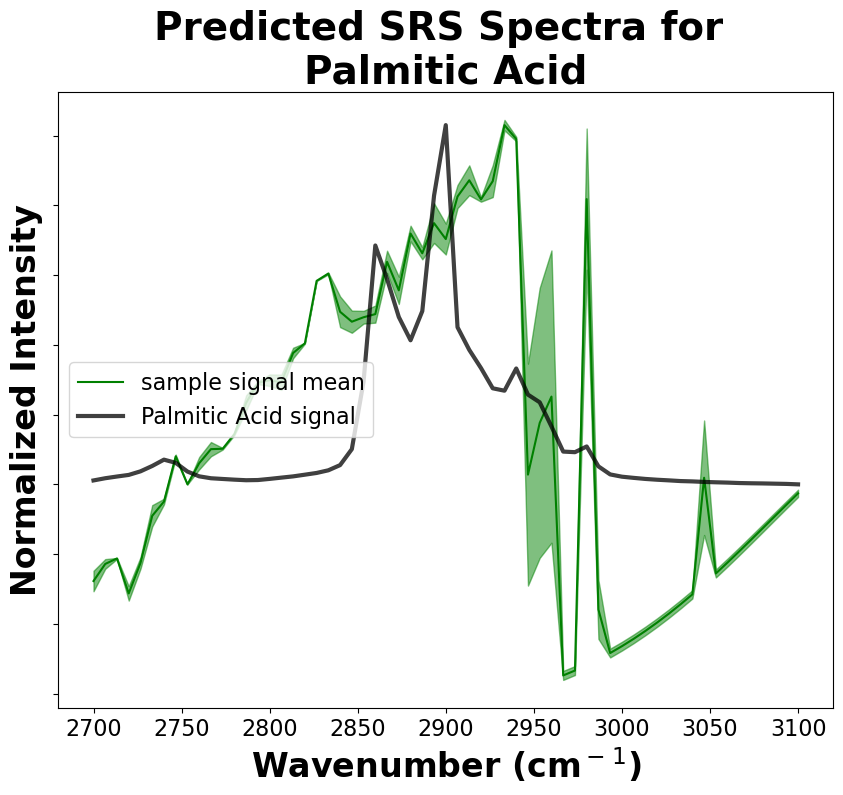

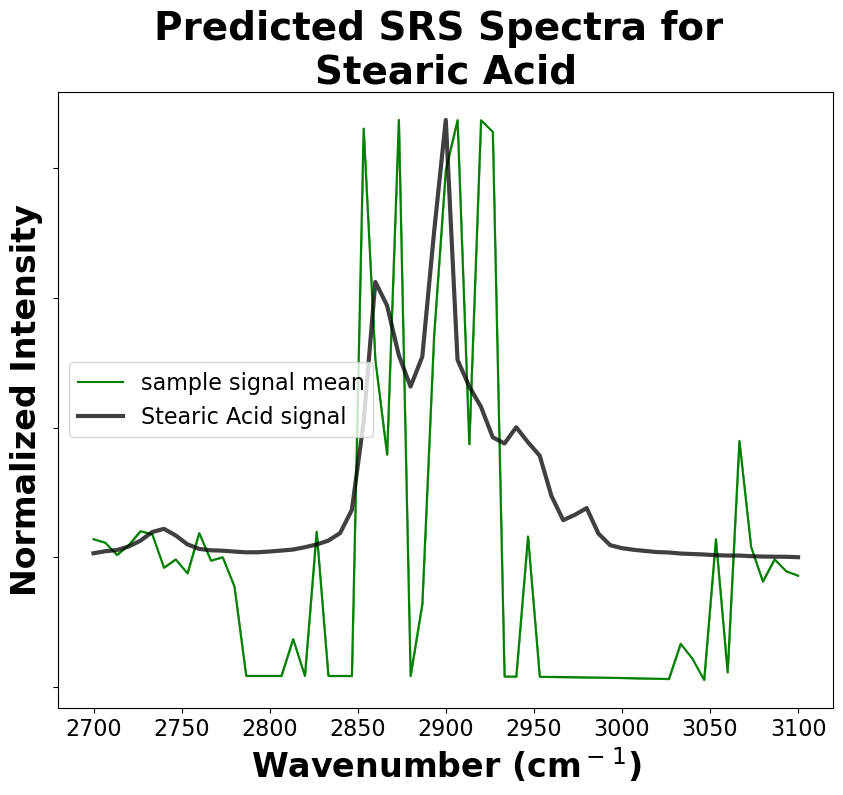

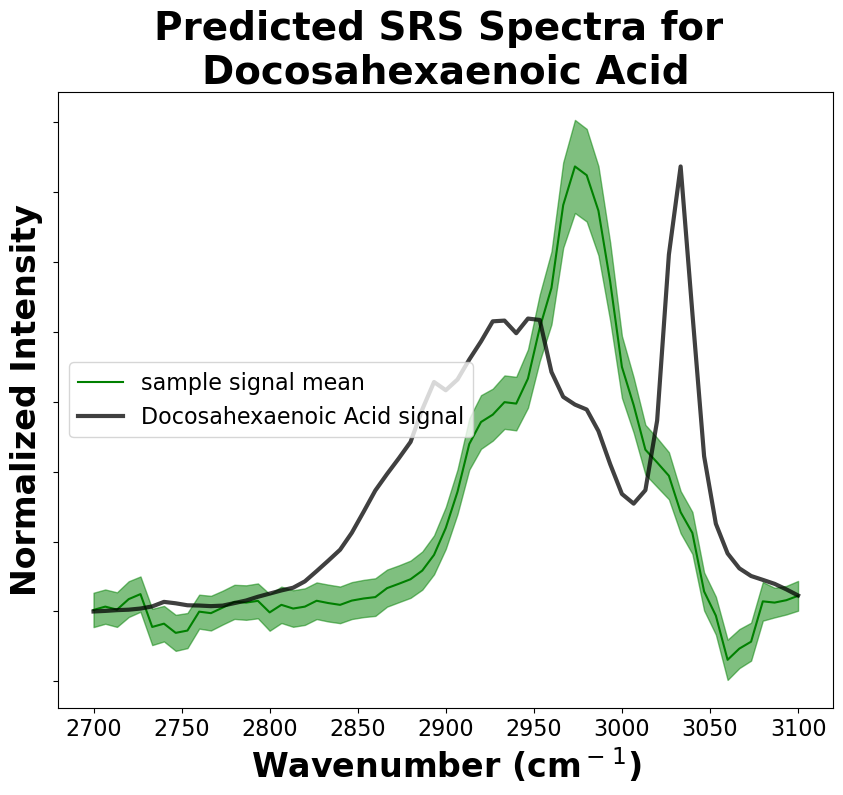

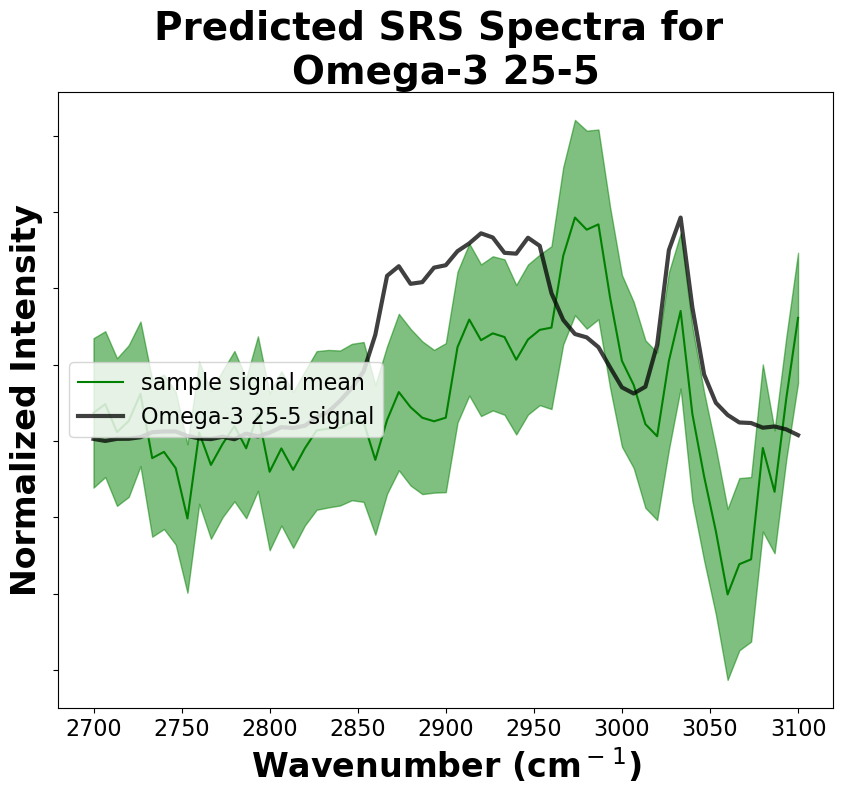

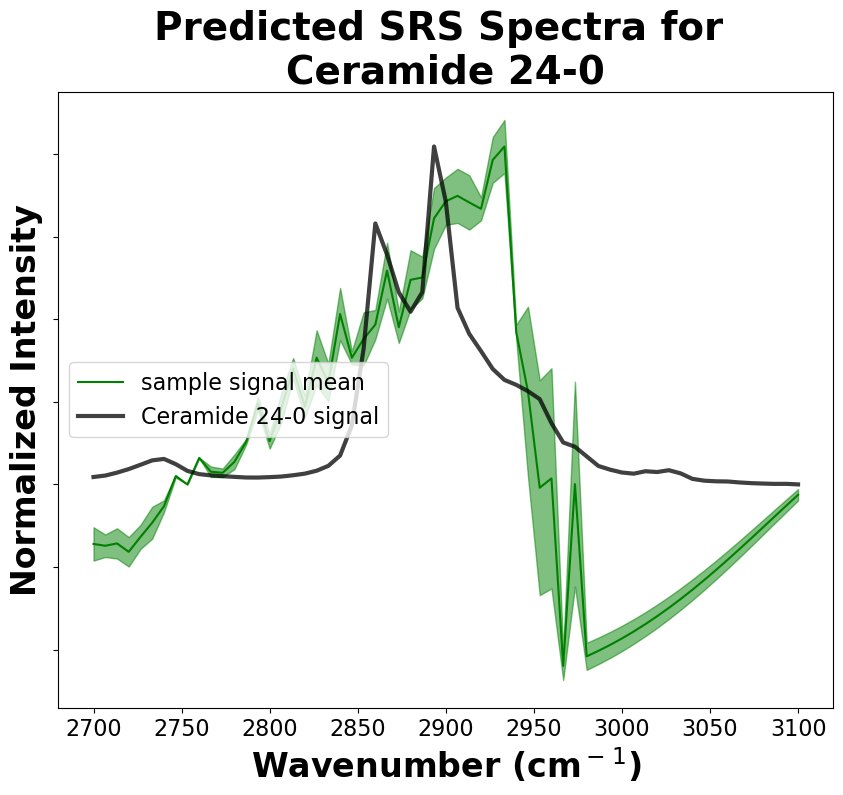

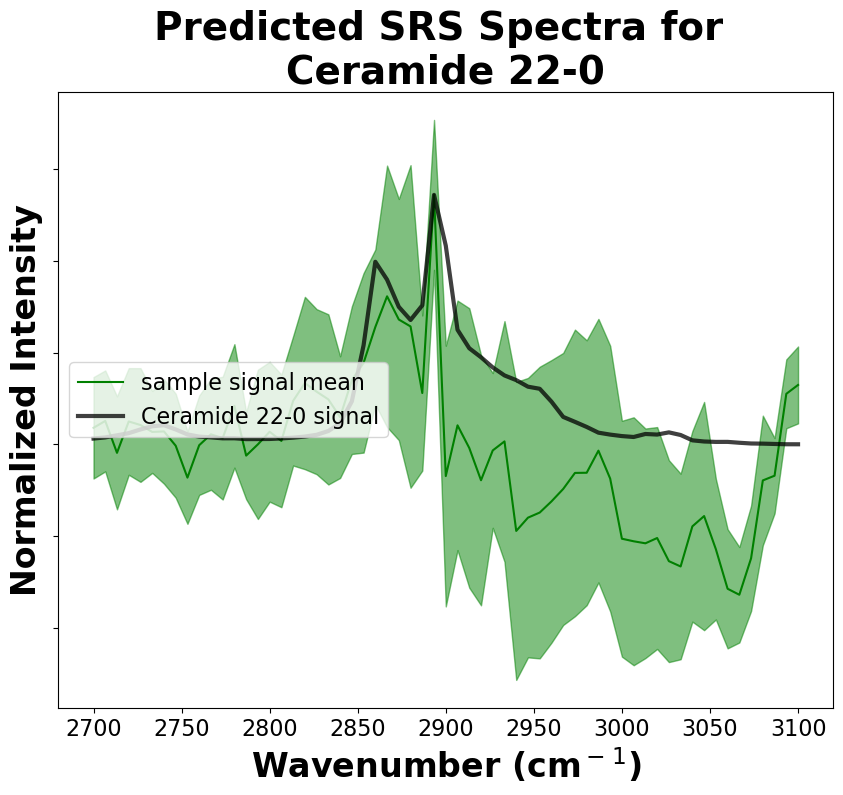

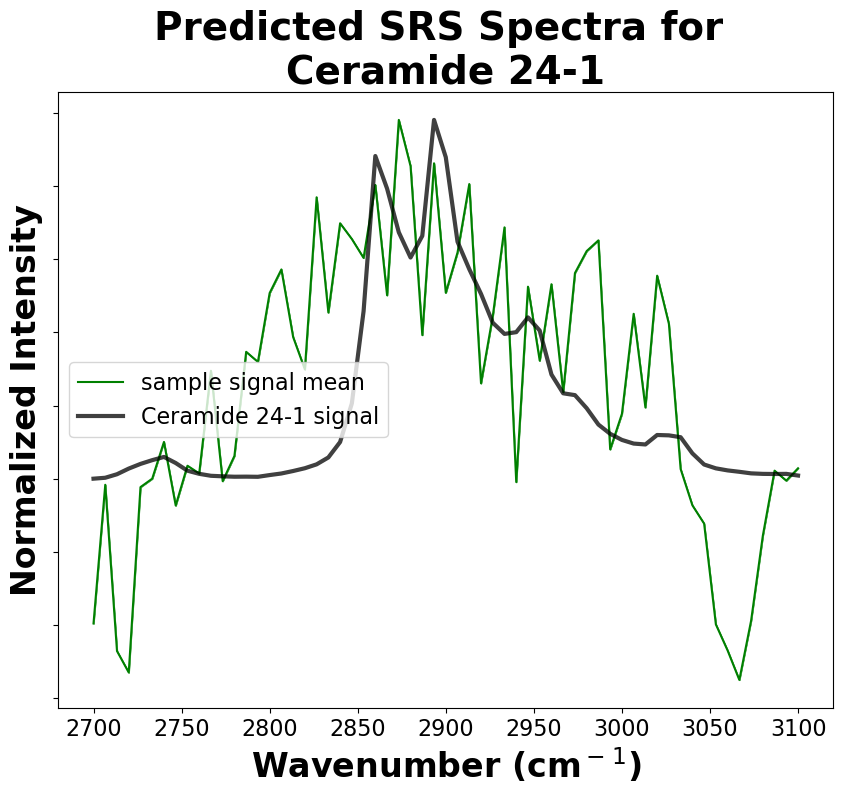

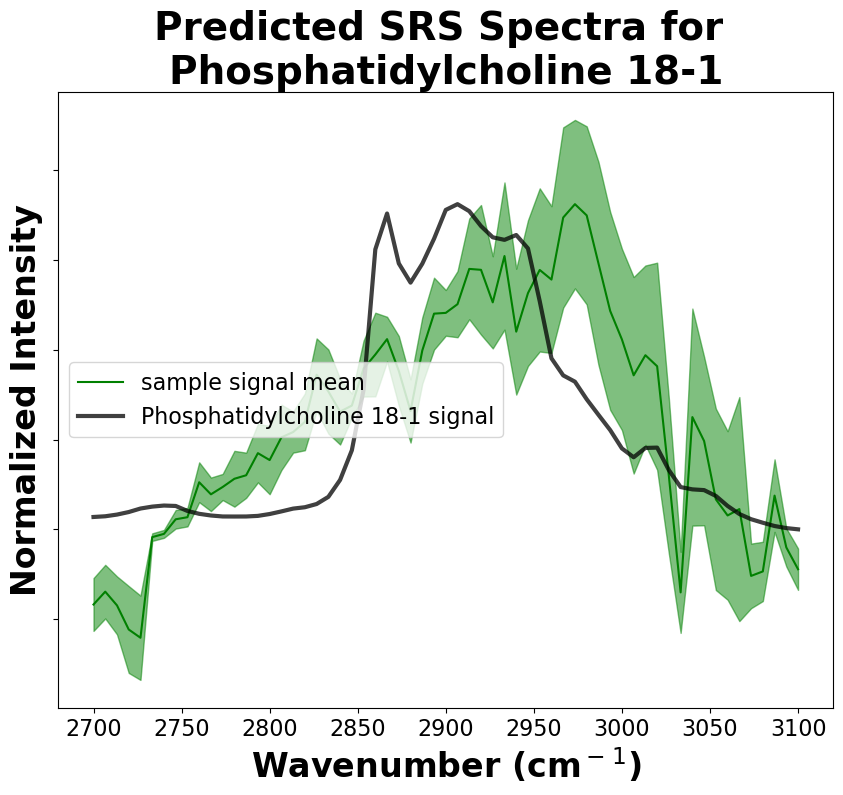

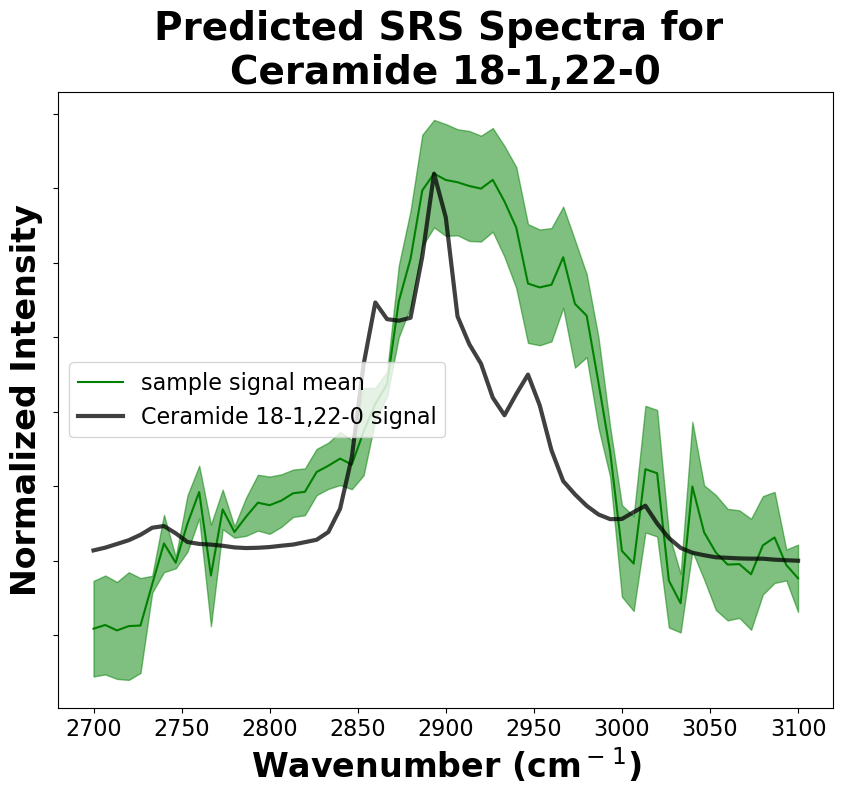

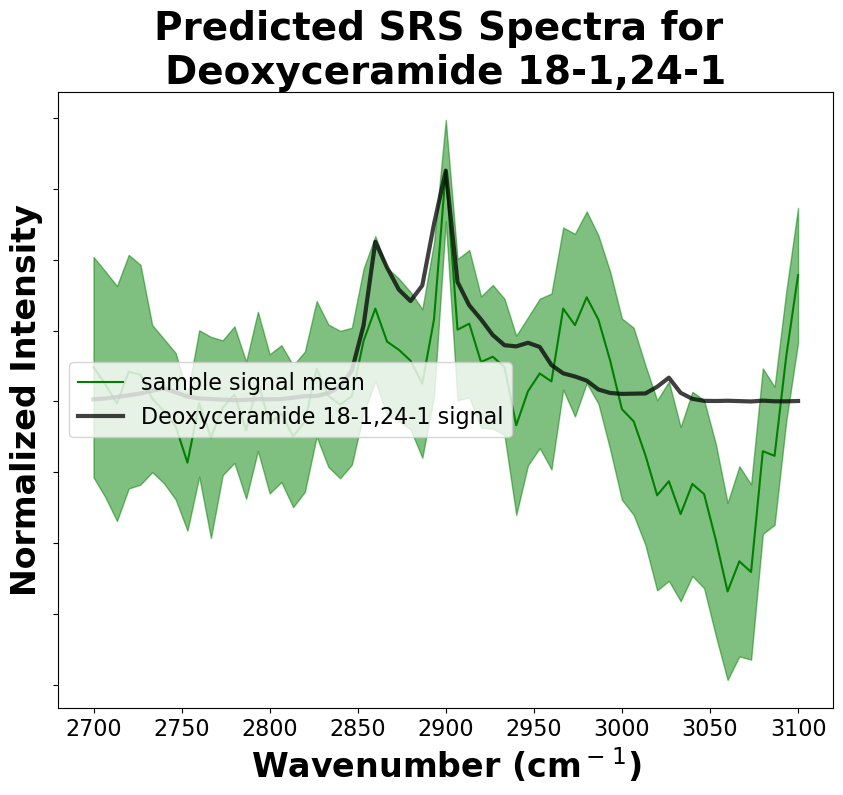

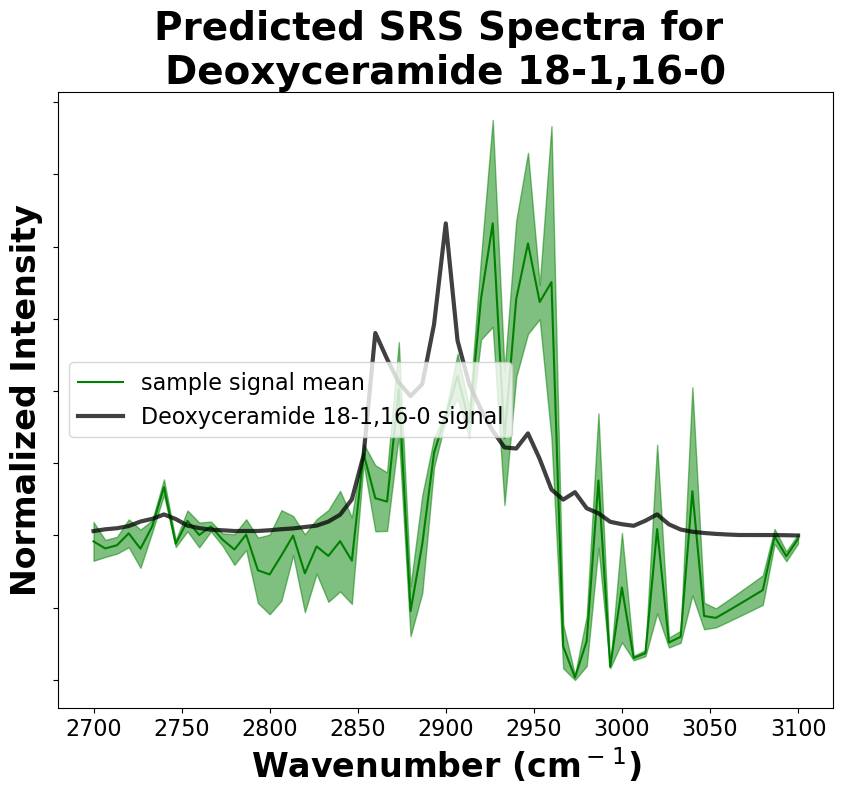

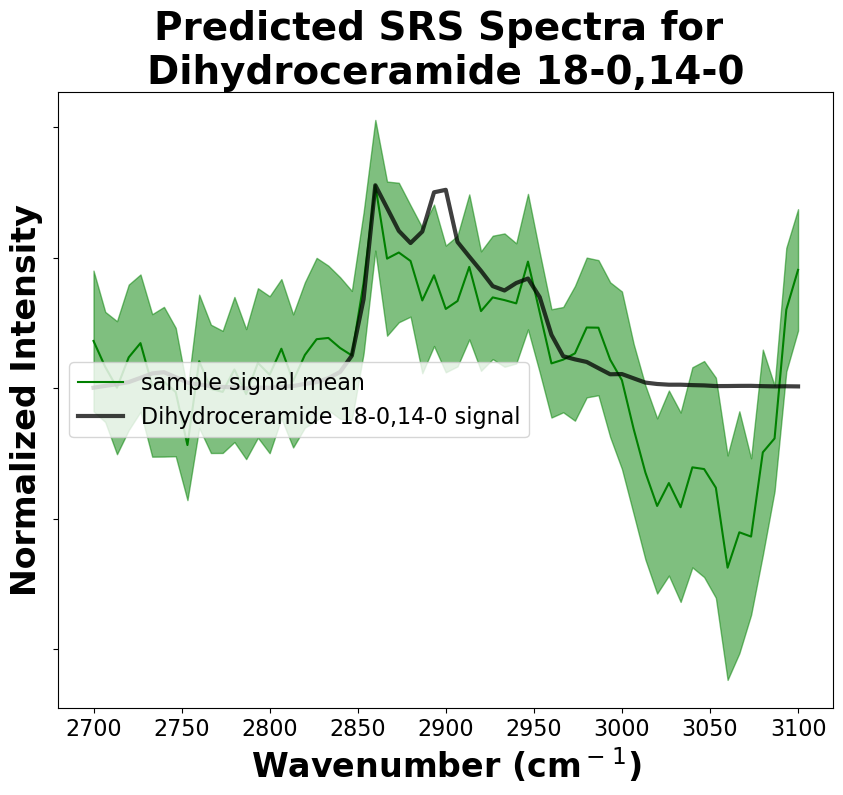

In [13]:
## Spectral Graphs
# save_input = helper_scripts.save_input()
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)
outputs.probability_images(image, save_input, save_dir)

In [ ]:
import helper_scripts
print('Save similarity metric .csv?')
ave_input = helper_scripts.save_input()
outputs.similarity_metrics(mol_norm, save_input, save_dir)

Save similarity metric .csv?


100%|██████████| 2411/2411 [00:00<00:00, 4834.05it/s]


The MSE for Phosphatidylethanolamine is: 0.002950058626004513
The Cosine Similarity for Phosphatidylethanolamine is: 0.4325834622459228
The Cross-Correlation for Phosphatidylethanolamine is: 0.533702697143132


 68%|██████▊   | 217610/318866 [00:47<00:20, 4877.73it/s]